In [94]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv
import numpy as np
import scipy.special as special
from time import time

-147.07320952415466
28.878520250320435


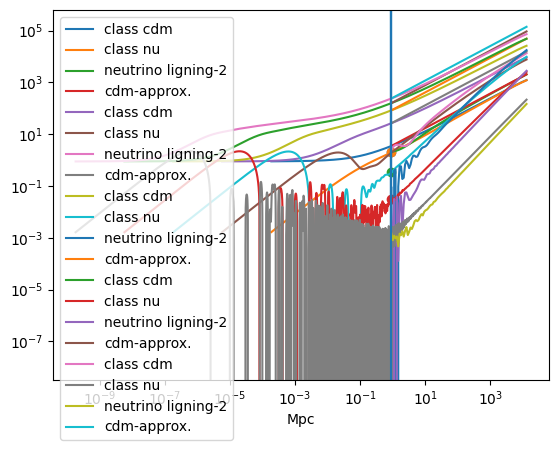

In [98]:
def TEST(kvec=[1],k_ind=0,z=600,mv_test=1 ,   Omega_M = 1/3,PLOT_FIGUR=True):
    # C kode funktions kopier for at jeg nemt og hurtigt kan importere CForm af mathmatica løsningerne.
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3}

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    # det kommer af Gyrs * c = 306.4 Mpc
    tid = bg['proper time [Gyr]'] * c / 306.4
    pts = cosmo.get_perturbations()['scalar']
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T0 / a / mv


    # henter class data
    #=======================
    delta_class = pts[k_ind]["delta_cdm"]
    #theta_class = pts[k_ind]["theta_cdm"]
    tau_class = pts[k_ind]["tau [Mpc]"]
    delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
    theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
    a_class = pts[k_ind]["a"]
    #=======================

    # interpolation af class data
    # ==============================
    tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
    interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
    interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class)
    delta_init = scipy.interpolate.interp1d(tau_class,delta_class)
    delta_tid = scipy.interpolate.interp1d(tid_class,delta_class)

    neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)
    theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
    neu_interp = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
    #a_interp = scipy.interpolate.interp1d(tau_class,a_class)
    #a_interp_tid = scipy.interpolate.interp1d(a_class,tid_class)
    # ===============================

        # valg af z-start værdi
    # ===============================
    a0 = 1/(1+z)
    a_span = [a0,1]
    # ===============================
    # danner start værdier for conformal og fysisk tid og delta_cdm
    # ===============================
    T_ini = float(interp_tau_from_a(a0))
    T_ini_tid = float(interp_tid_from_a(a0))
    T_0 =  float(T_ini_tid)
    delta0 = delta_init(T_ini)
    # ===============================


    # Jeg har skreve cs(a) som c/a i mathmatica så vi definere først c som konstant
    # ===============================
    c = cs(1)
    # ===============================

    # diff ligning i fysisk tid
    # ===============================
    t0 = tid[-1]

    #y0 = np.array([neu_interp(a0),0])
    t = [T_0,tid[-1]]
    a0 = ((T_0)/tid[-1])**(2/3)
    #sol = scipy.integrate.solve_ivp(func,t,y0,args=(a0,))
    # ===============================

    plt.figure(2)
    plt.loglog(tid_class,-delta_class,label="class cdm")
    plt.plot(tid_class,-delta_neutrino_class,label="class nu")

    #plt.plot(sol.t,-sol.y[0],label="sim nu")
    plt.xlabel("Mpc")
    plt.scatter(T_ini_tid,-neu_interp(a0))
    t = np.logspace(np.log10(T_0),np.log10(tid[-1]),100)


    def f2(t):
        C1 = np.sqrt(neu_tid(T_0)**2 + (theta_neu_tid(T_0)*a0/ (cs(a0)*k))**2)
        C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
        dcdm = delta0/a0        
        a = (t/t0)**(2/3)
        val = 3 * cs(a) * k * t0 * np.sqrt(a)        
        return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 
    
    if PLOT_FIGUR==True:
        plt.loglog(t,-f2(t),label="neutrino ligning-2")
        # den er her hvis man lige skal overbevise sigselv om hvorfor man ikke skal bruge ligningen før z
        #plt.loglog(tid_class,-f2(tid_class),label="neutrino ligning-2")
        plt.loglog(t,-delta0/a0*Power(t/t0,2/3),label="cdm-approx.")
        plt.legend()
        plt.axvline(T_0) 

    return f2(t0)

t1 = time()
for i in np.logspace(-2,1,5):
    s = TEST(kvec=[i],k_ind=0,z=600,mv_test=1,Omega_M = 0.3,PLOT_FIGUR=False)
t2 = time()
print(s)
print(t2-t1)

#plt.savefig("test")

Text(0.5, 1.0, 'neutrino mass = 100 eV')

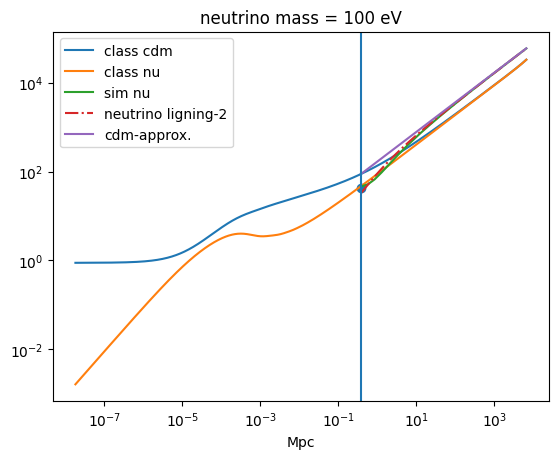

In [72]:

TEST(kvec=[1],k_ind=0,z=600,mv_test=100,Omega_M = 0.3)
plt.title("neutrino mass = 100 eV")

-0.38898658686706067


Text(0.5, 1.0, 'neutrino mass = 0.1 eV')

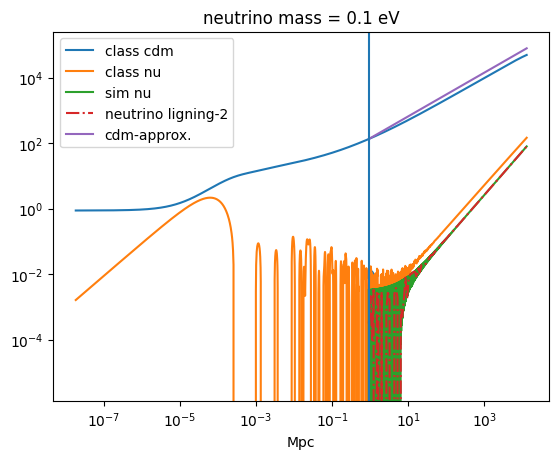

In [68]:
TEST(kvec=[1],k_ind=0,z=600,mv_test=0.1,Omega_M = 0.3)
plt.title("neutrino mass = 0.1 eV")

Vi starter i $t_s$ og slutter i $t_0$ (idag)

$\ddot{\delta} +2 H \dot{\delta} + \frac{c_s ^2 k^2}{a^4}\delta = \frac{3}{2} H^2 \delta_{cdm}$

$\delta_{cdm} = \frac{\delta_{cdm,ts}}{a_s} a$

Hvor $a_s =  \left(\frac{t_s}{t_0}\right) ^{2/3}$

$a = \left(\frac{t}{t_0}\right) ^{2/3}$

$ H = \frac{2}{3} \frac{1}{t}$

i Mathmatica:

$ K1 = \delta_{cdm,ts} / a_s$

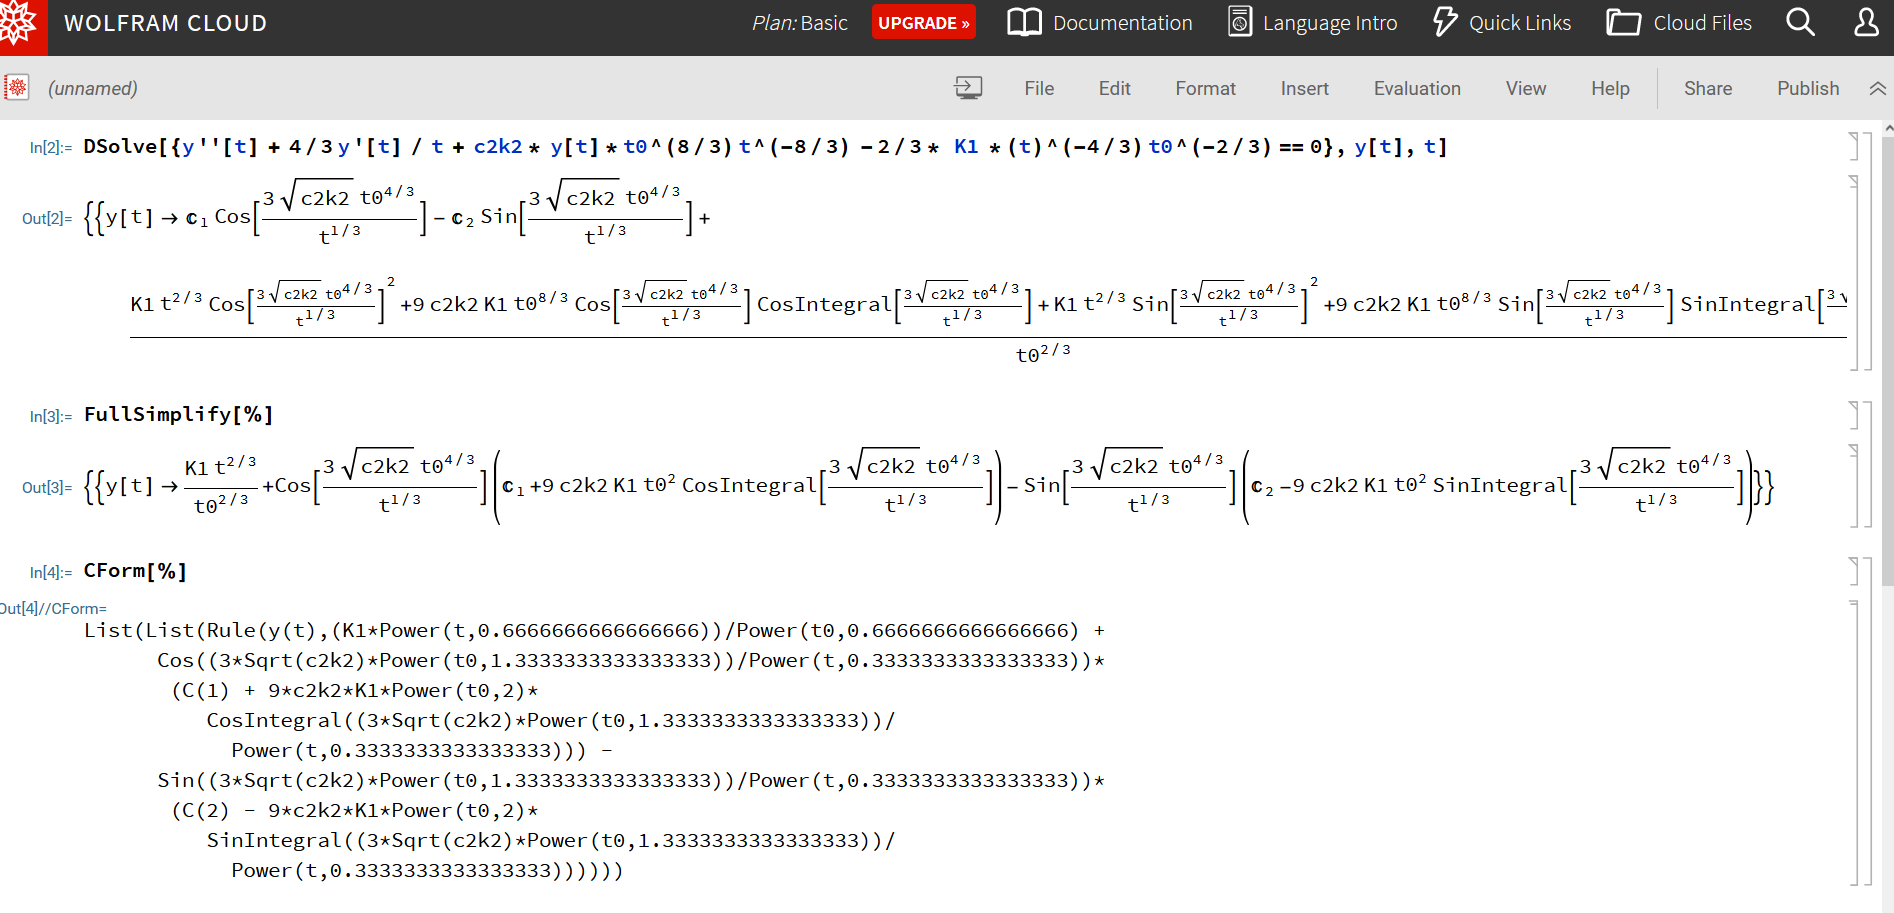

$A = 3 c_s(a=1) k t_0\; B = 3 c_s(a_{ts}) k t_s / a_{ts}$



$S_I A = sinIntegral(A)$

$C_I A = cosIntegral(A)$

$S_I B = sinIntegral(B)$

$C_I B = cosIntegral(B)$

$S_A = sin(A)\; C_A = cos(A) \; S_B = sin(B) \; C_B = cos(B)$

$c_1 = \frac{\delta_{ts}-\delta_{\nu,ts} + \delta(t_s)B^2 C_IB + s_B \delta_{ts} B^2 S_IB - \frac{s_B}{s_A}(\delta(t_0)-\delta_{\nu,t_0} + c_A \delta_{t_0} A^2 C_IA + s_A \delta_{t_0}A^2 S_I A)  }{S_BC_A/S_A - C_B}\;$
$c_2 = \frac{1}{s_A}(\delta_{t_0}-\delta_{\nu,t_0}+c_A \delta_{t_0} A^2 C_IA s_A \delta_{t_0} A^2 S_I A) + \frac{c_A}{s_A}c_1$


$\delta_{\nu} = \delta_{cdm} + \cos(3c_s(a) kt/a) \left(c_1 + \delta_{cdm} (3c_s(a)kt/a)^2cosInt(3c_s(a)kt/a)\right) - \sin(3c_s(a)kt/a)\left(c_2 - \delta_{cdm}(3c_s(a)kt/a)^2SinInt(3c_s(a)kt/a)\right)$


In [104]:
def sim(kvec=[1],k_ind=0,z=600,mv_test=1 ,   Omega_M = 1/3):
    # C kode funktions kopier for at jeg nemt og hurtigt kan importere CForm af mathmatica løsningerne.
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3}

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    # det kommer af Gyrs * c = 306.4 Mpc
    tid = bg['proper time [Gyr]'] * c / 306.4
    pts = cosmo.get_perturbations()['scalar']
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T0 / a / mv


    # henter class data
    #=======================
    klist = np.zeros(len(kvec))
    for k_ind,k in enumerate(kvec):
        delta_class = pts[k_ind]["delta_cdm"]
        #theta_class = pts[k_ind]["theta_cdm"]
        tau_class = pts[k_ind]["tau [Mpc]"]
        delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
        theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
        a_class = pts[k_ind]["a"]
        #=======================

        # interpolation af class data
        # ==============================
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class)
        delta_init = scipy.interpolate.interp1d(tau_class,delta_class)
        delta_tid = scipy.interpolate.interp1d(tid_class,delta_class)

        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        neu_interp = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
        #a_interp = scipy.interpolate.interp1d(tau_class,a_class)
        #a_interp_tid = scipy.interpolate.interp1d(a_class,tid_class)
        # ===============================

            # valg af z-start værdi
        # ===============================
        a0 = 1/(1+z)
        a_span = [a0,1]
        # ===============================
        # danner start værdier for conformal og fysisk tid og delta_cdm
        # ===============================
        T_ini = float(interp_tau_from_a(a0))
        T_ini_tid = float(interp_tid_from_a(a0))
        T_0 =  float(T_ini_tid)
        delta0 = delta_init(T_ini)
        # ===============================


        # Jeg har skreve cs(a) som c/a i mathmatica så vi definere først c som konstant
        # ===============================
        c = cs(1)
        # ===============================

        # diff ligning i fysisk tid
        # ===============================
        t0 = tid[-1]

        #y0 = np.array([neu_interp(a0),0])
        t = [T_0,tid[-1]]
        a0 = ((T_0)/tid[-1])**(2/3)
        #sol = scipy.integrate.solve_ivp(func,t,y0,args=(a0,))
        # ===============================


        def f2(t):
            C1 = np.sqrt(neu_tid(T_0)**2 + (theta_neu_tid(T_0)*a0/ (cs(a0)*k))**2)
            C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
            dcdm = delta0/a0        
            a = (t/t0)**(2/3)
            val = 3 * cs(a) * k * t0 * np.sqrt(a)        
            return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 
        klist[k_ind] = f2(t0)
    return klist

t1 = time()
s = sim(kvec=list(np.logspace(-2,1,5)))
t2 = time()
print(s)
print(t2-t1)


[ -1965.73533259 -13577.7912466  -19050.02833737  -3158.7283551
   -167.68681049]
4.718309640884399


In [105]:
Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
Tv_k = 1.947
# in MeV
kb = 8.617e-11 # MeV/K
T0 = Tv_k * kb
H0 = 67 / (3*1e5) # i 1/Mpc
mv_test = 1 # eV
kvec = np.logspace(-3,1,30)
h = 0.6704
cosmo_dict ={'h':h,  'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
             "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
           ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
            "ncdm_fluid_approximation":3
            }
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()
pts = cosmo.get_perturbations()['scalar']
#print(bg.keys())
z = bg["z"]
a = 1/(z+1)
aend = a[-1]
a0 = a[0]
mv = mv_test * 1e-6
tranf = cosmo.get_transfer(z=0)
#print(tranf.keys())
prim = cosmo.get_primordial()
#print(prim.keys())

k = tranf['k (h/Mpc)'] * h
#plt.loglog(tranf['k (h/Mpc)'],-tranf["d_ncdm[0]"])

prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")


In [83]:
#print(k)

In [108]:
test = sim(kvec=list(kvec))


In [109]:
print(test)

[  -665.20277344   -677.97996043   -702.02574606   -747.21376903
   -831.7707619    -988.71710575  -1275.80730932  -1787.54078181
  -2659.74462374  -4043.17955372  -6022.41611867  -8528.04566008
 -11408.15163762 -14589.97122668 -17605.60628258 -20012.3872524
 -21281.58761649 -21076.66032862 -19360.28195164 -16437.91635964
 -12901.54283831  -9395.83909716  -6400.47474831  -4124.52974711
  -2546.63597086  -1524.62635349   -893.58260136   -516.22264707
   -295.27429515   -167.68681049]


hvor vi lige fjerner en faktor 2


Text(0.5, 1.0, 'neutrino power sepctrum for a neutrino of mass 1 eV')

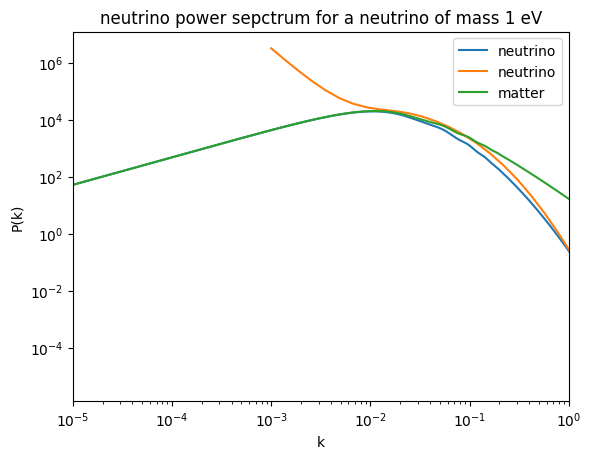

In [121]:
print("hvor vi lige fjerner en faktor 2")
plt.figure(1)
plt.loglog(k, 2*np.pi**2 * tranf["d_ncdm[0]"]**2* k**(-3) * prim_interp(k) * h**3,label="neutrino")
plt.loglog(kvec, np.pi**2 * test**2 * kvec**(-3) * prim_interp(kvec) * h**3,label="neutrino")
plt.loglog(k, 2*np.pi**2 * tranf["d_m"]** 2 *k**(-3) *  prim_interp(k) * h**3,label="matter")
plt.xlim([1e-5,1])
plt.legend()
plt.xlabel("k")
plt.ylabel("P(k)")
plt.title("neutrino power sepctrum for a neutrino of mass %s eV" % mv_test)

In [3]:
"""
def f2(t,ta,delta0,
       theta0,dcdm,t_idag, mv_test=1# i eV
       ,k=1):
        mv = mv_test * 1e-6
        a = (t/t_idag)**(2/3)
        astart = (ta/t_idag)**(2/3)
        def cs(a):
            Tv_k = 1.947 # kelvin # MeV
            kb = 8.617e-11 # MeV/K
            T0 = Tv_k * kb
            mv = mv_test * 1e-6
            cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
            cs_factor /= 4
            return cs_factor *T0 / a / mv

    
        C1 = np.sqrt(delta0**2 + (theta0*astart/ (cs(astart)*k))**2)
        C2 = np.pi / 2 * ( 3 * cs(astart) * k * t0 * astart )**2 * (delta0/astart)
        dcdm /= astart      
        val = 3 * cs(a) * k * t0 * np.sqrt(a)        
        return dcdm*a+C1*np.cos(val)+val**2*a*dcdm*np.cos(val)*special.sici(val)[1]-C2*np.sin(val)+val**2*a*dcdm*np.sin(val)*special.sici(val)[0]
    
t = np.logspace(0,4,100)
t0 = 1e4
a = (t/t0)**(2/3)

plt.loglog(t,-f2(t,t[0],1e-2,-0.3,1e2,t0))"""
        

[ -1965.73533259 -13577.7912466  -19050.02833737  -3158.7283551
   -167.68681049]
4.351545810699463
